## Task 4 : Logistic Regression in TensorFlow

#### Load of Packages

In [ ]:
import os
import pickle
import numpy as np
import sys
import random
import csv
import cv2
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from collections import  Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import skimage.morphology as morp
from skimage.filters import rank
from tensorflow.contrib.layers import flatten
from sklearn.metrics import confusion_matrix

In [3]:
os.chdir('C:/Users/admin/Desktop/GitHub/German-Traffic-Signs-Detector')
plt.style.use('ggplot')

#### Load of dmata


In [4]:

features = "Features.p"
target = "Target.p"

with open(features, mode='rb') as f:
    features = pickle.load(f)
with open(target, mode='rb') as f:
    target = pickle.load(f)

##### Partitioning into training data and test data

In [5]:

#taking random data from the dataset
x,y=shuffle(features,target,random_state=2)

#spliting the data into test and train
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=4)


y_test = y_test.astype(int)

y_train = y_train.astype(int)


In [6]:
# Number of training examples
n_train = len(x_train)
print("Número de Registros de Entrenameinto =", n_train)

# Number of testing examples.
n_test = len(x_test)
print("Número de registros de Testeo =", n_test)

# What's the shape of an traffic sign image?
image_shape = x_train[0].shape
print("Forma de la estructura de datos de la imagen =", image_shape)

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))
print("Número de Clases =", n_classes)

Número de Registros de Entrenameinto = 970
Número de registros de Testeo = 243
Forma de la estructura de datos de la imagen = (32, 32, 3)
Número de Clases = 42


#### Mapping ClassID to traffic sign names

In [7]:

# Mapping ClassID to traffic sign names
targets = []
with open('targets.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        targets.append(row[1])
    csvfile.close()

#### Function to plot a data grid

In [8]:


def list_images(dataset, dataset_y, ylabel="", cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            lanel (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(12, 12))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(targets[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()




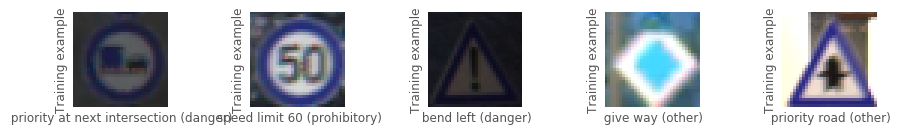

In [9]:
# Plotting sample examples
list_images(x_train, y_train, "Training example")


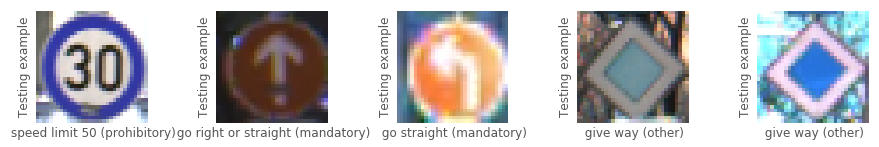

In [10]:
list_images(x_test, y_test, "Testing example")

In [11]:

def histogram_plot(dataset, label):
    """
    Plots a histogram of the input data.
        Parameters:
            dataset: Input data to be plotted as a histogram.
            lanel: A string to be used as a label for the histogram.
    """
    hist, bins = np.histogram(dataset, bins=n_classes)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel(label)
    plt.ylabel("Image count")
    plt.show()



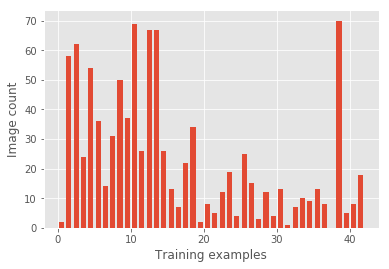

In [12]:

histogram_plot(y_train, "Training examples")


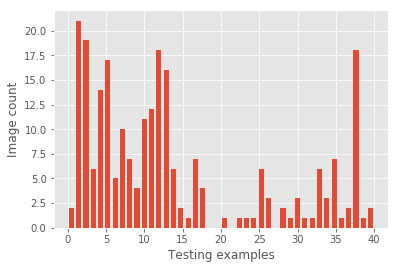

In [13]:
histogram_plot(y_test, "Testing examples")

### Data Preprocessing

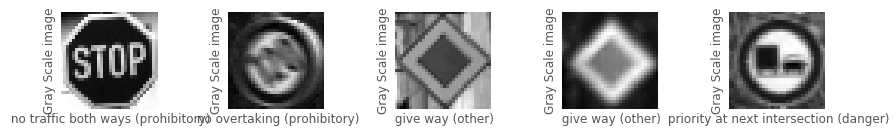

In [15]:

def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Sample images after greyscaling
gray_images = list(map(gray_scale, x_train))

list_images(gray_images, y_train, "Gray Scale image", "gray")


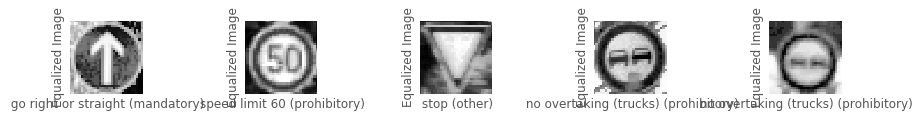

In [16]:
def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local



# Sample images after Local Histogram Equalization# Sample 
equalized_images = list(map(local_histo_equalize, gray_images))
list_images(equalized_images, y_train, "Equalized Image", "gray")


In [17]:

def image_normalize(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return(image - image.min()) / ((image.max() - image.min()))
    

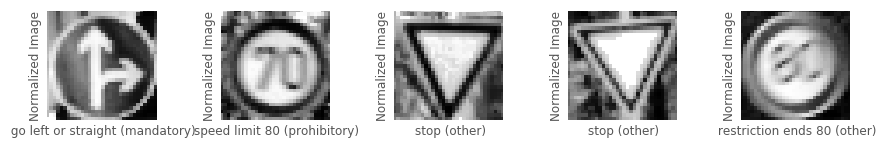

In [18]:
normalized_images = np.zeros((x_train.shape[0], x_train.shape[1], x_train.shape[2]))
for i, img in enumerate(equalized_images):
    normalized_images[i] = image_normalize(img)
    
list_images(normalized_images, y_train, "Normalized Image", "gray")
normalized_images = normalized_images[..., None]

In [19]:
def preprocess(data):
    """
    Applying the preprocessing steps to the input data.
        Parameters:
            data: An np.array compatible with plt.imshow.
    """
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images


In [22]:


x_preprocessed = preprocess(x_train)
x_test_preprocessed = preprocess(x_test)


nsamples, nx, ny, channels = x_preprocessed.shape
logistic_train = x_preprocessed.reshape((nsamples,nx*ny))

nsamples, nx, ny, channels = x_test_preprocessed.shape
logistic_test = x_test_preprocessed.reshape((nsamples,nx*ny))


In [48]:

earning_rate = 0.02
training_epochs = 50
beta = 0.05

tf.reset_default_graph()

# By aving 2 features: hours slept & hours studied
X = tf.placeholder(tf.float32, [None, 1024], name="X")
Y = tf.placeholder(tf.float32, [None, 42], name="Y")

# Initialize our weigts & bias
W = tf.get_variable("W", [1024, 42], initializer = tf.contrib.layers.xavier_initializer())
b = tf.get_variable("b", [42], initializer = tf.zeros_initializer())

Z = tf.add(tf.matmul(X, W), b)
prediction = tf.nn.sigmoid(Z)

# Calculate the cost
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Z, labels = Y))

    # Loss function using L2 Regularization
regularizer = tf.nn.l2_loss(W)
loss = tf.reduce_mean(cost + beta * regularizer)

# Use Adam as optimization method
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

cost_history = np.empty(shape=[1],dtype=float)


In [49]:

train_small_with_dummies = pd.get_dummies(y_train, sparse=False)

pru = train_small_with_dummies.as_matrix()

y_reshape2 =pru.reshape(pru.shape[0], 42)


train_small_with_dummies = pd.get_dummies(y_test, sparse=False)

pru = train_small_with_dummies.as_matrix()

y_test_reshape2 =pru.reshape(pru.shape[0], 38)




In [50]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(training_epochs):
        _, c = sess.run([optimizer, cost], feed_dict={X: logistic_train, Y: y_reshape2})
       # print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), \
       #       "W=", sess.run(W), "b=", sess.run(b))
        cost_history = np.append(cost_history, c)
        
        
    # Calculate the correct predictions
    correct_prediction = tf.to_float(tf.greater(prediction, 0.5))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.to_float(tf.equal(Y, correct_prediction)))
    print ("Train Accuracy:", accuracy.eval({X: logistic_train, Y: y_reshape2}))
        

Train Accuracy: 0.982597


In [35]:
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver.save(sess, 'models/TFLogistic/TFLogistic')

'models/TFLogistic/TFLogistic'